In [18]:
from datetime import datetime
import pandas as pd
import matplotlib.pyplot as plt
import re
from os import listdir
from os.path import isfile, join
import json

folder = "flight-user"
date = "2021-05-02"


onlyfiles = [f for f in listdir(join(folder, date)) if isfile(join(join(folder, date), f))]


print(len(onlyfiles))
onlyfiles[:5]

74


['csv-2021-05-02-09-50-03-snore-1035-iPhone10-9-37.33-59.11-09-49-06.356-56.55-50.65-34.53.csv',
 'csv-2021-05-02-09-34-03-none-1035-iPhone10-0-30.42-52.37-null-NMSnore-NAvgSnore-30.17.csv',
 'csv-2021-05-02-09-45-03-none-1035-iPhone10-0-33.52-52.28-null-NMSnore-NAvgSnore-33.22.csv',
 'csv-2021-05-02-10-17-03-none-1035-iPhone10-0-30.47-40.68-null-NMSnore-NAvgSnore-30.31.csv',
 'csv-2021-05-02-10-41-03-none-1035-iPhone10-0-32.61-49.69-null-NMSnore-NAvgSnore-32.43.csv']

In [19]:
def parse_file_name(file_name):
    pattern = r"csv-(\d{4}-\d{2}-\d{2})-(\d{2}-\d{2}-\d{2})-(\w+)-(\d+)-iPhone\d+-(\d+)-(\d+\.\d+)-(\d+\.\d+)-(\d{2}-\d{2}-\d+\.\d+|null)-(NMSnore|\d+\.\d+)-(NAvgSnore|\d+\.\d+)-(\d+\.\d+|\-inf).csv"
    match = re.match(pattern, file_name)
    if match:
        return {
            "date": match.group(1),
            "time": match.group(2),
            "event_type": match.group(3),
            "version": int(match.group(4)),
            "snore_count": int(match.group(5)),
            "avg_db": float(match.group(6)),
            "max_db": float(match.group(7)),
            "start_snore_event_timestamp": match.group(8),
            "max_snore_db": match.group(9),
            "avg_snore_db": match.group(10),
            "noise_level": match.group(11),
        }
    else:
        print(file_name)
        raise Exception("Not possible")


parsed_data = [
    parse_file_name(fn) for fn in onlyfiles if parse_file_name(fn) is not None
]

df = pd.DataFrame(parsed_data)
df["datetime"] = df.apply(
    lambda row: datetime.strptime(f"{row['date']} {row['time']}", "%Y-%m-%d %H-%M-%S"),
    axis=1,
)
df = df.drop(["date", "time"], axis=1)

df = df.sort_values(by="datetime")

df_hour = df.copy()

df_hour["hour"] = df["datetime"].dt.hour


df.reset_index(inplace=True)
df = df.drop(columns=["index"])
df.describe()

,version,snore_count,avg_db,max_db,datetime
count,74.0,74.000000,74.000000,74.000000,74
mean,1035.0,1.175676,33.055270,47.932703,2021-05-02 10:08:33
min,1035.0,0.000000,29.850000,31.250000,2021-05-02 09:32:03
25%,1035.0,0.000000,30.922500,41.172500,2021-05-02 09:50:18
50%,1035.0,0.000000,32.760000,50.215000,2021-05-02 10:08:33
75%,1035.0,1.750000,34.757500,52.945000,2021-05-02 10:26:48
max,1035.0,10.000000,40.770000,61.950000,2021-05-02 10:45:03
std,0.0,2.089492,2.396661,7.807916,NaN


In [20]:
# df = df[df["event_type"] == "snore"]
df["max_snore_db"] = df["max_snore_db"].astype(float)
df["avg_snore_db"] = df["avg_snore_db"].astype(float)
df["noise_level"] = df["noise_level"].astype(float)
df.dtypes

event_type                             object
version                                 int64
snore_count                             int64
avg_db                                float64
max_db                                float64
start_snore_event_timestamp            object
max_snore_db                          float64
avg_snore_db                          float64
noise_level                           float64
datetime                       datetime64[ns]
dtype: object

In [21]:
def apply_increase_level(noise_level, avg_snore_db):
    percentage_increase = ((avg_snore_db - noise_level) / noise_level) * 100
    return percentage_increase


df["noise_increase_percentage"] = df.apply(
    lambda row: apply_increase_level(row["noise_level"], row["avg_snore_db"]), axis=1
)

df.head(15)

,event_type,version,snore_count,avg_db,max_db,start_snore_event_timestamp,max_snore_db,avg_snore_db,noise_level,datetime,noise_increase_percentage
10,snore,1035,3,31.62,50.31,09-41-55.732,44.93,44.56,30.96,2021-05-02 09:42:03,43.927649
11,snore,1035,1,33.92,55.34,09-42-52.855,44.41,44.41,33.44,2021-05-02 09:43:03,32.805024
12,snore,1035,6,34.85,52.95,09-43-11.853,48.49,45.25,34.11,2021-05-02 09:44:03,32.659044
14,snore,1035,2,34.21,55.62,09-45-11.731,49.95,46.45,33.68,2021-05-02 09:46:03,37.915677
16,snore,1035,6,33.55,51.14,09-47-44.108,51.14,49.31,31.91,2021-05-02 09:48:03,54.528361
17,snore,1035,6,37.80,61.05,09-48-36.105,57.89,56.47,34.68,2021-05-02 09:49:03,62.831603
18,snore,1035,9,37.33,59.11,09-49-06.356,56.55,50.65,34.53,2021-05-02 09:50:03,46.684043
19,snore,1035,10,40.77,61.28,09-50-05.484,59.90,57.16,37.26,2021-05-02 09:51:03,53.408481
23,snore,1035,1,36.52,52.69,09-54-58.606,49.32,49.32,36.16,2021-05-02 09:55:03,36.393805
25,snore,1035,1,34.64,51.77,09-56-57.356,44.74,44.74,33.98,2021-05-02 09:57:03,31.665686


In [22]:
df["datetime"] = pd.to_datetime(df["datetime"])

thresholds = {"Quiet": 10, "Light": 20, "Loud": 30, "Severe": 100}


def categorize_noise_level(row):
    for category, threshold in thresholds.items():
        if row["noise_increase_percentage"] < threshold:
            return category
    return "Quiet"


df["category"] = df.apply(categorize_noise_level, axis=1)

grouped = df.groupby([pd.Grouper(key="datetime", freq="15T"), "category"])

grouped_daily = df.groupby([pd.Grouper(key="datetime", freq="D"), "category"])

# grouped.head()
counts = grouped.size().reset_index(name="counts")
counts_daily = grouped_daily.size().reset_index(name="counts")

# counts
pivot_table = counts.pivot(
    index="datetime", columns="category", values="counts"
).fillna(0)

pivot_table_daily = counts_daily.pivot(
    index="datetime", columns="category", values="counts"
).fillna(0)

pivot_table

category,Light,Loud,Quiet,Severe
datetime,,,,
2021-05-02 09:30:00,0.0,0.0,0.0,3.0
2021-05-02 09:45:00,0.0,0.0,0.0,9.0
2021-05-02 10:00:00,1.0,1.0,1.0,8.0
2021-05-02 10:15:00,0.0,2.0,1.0,1.0
2021-05-02 10:30:00,0.0,1.0,0.0,2.0


In [23]:

pivot_table_daily

category,Light,Loud,Quiet,Severe
datetime,,,,
2021-05-02,1,4,2,23


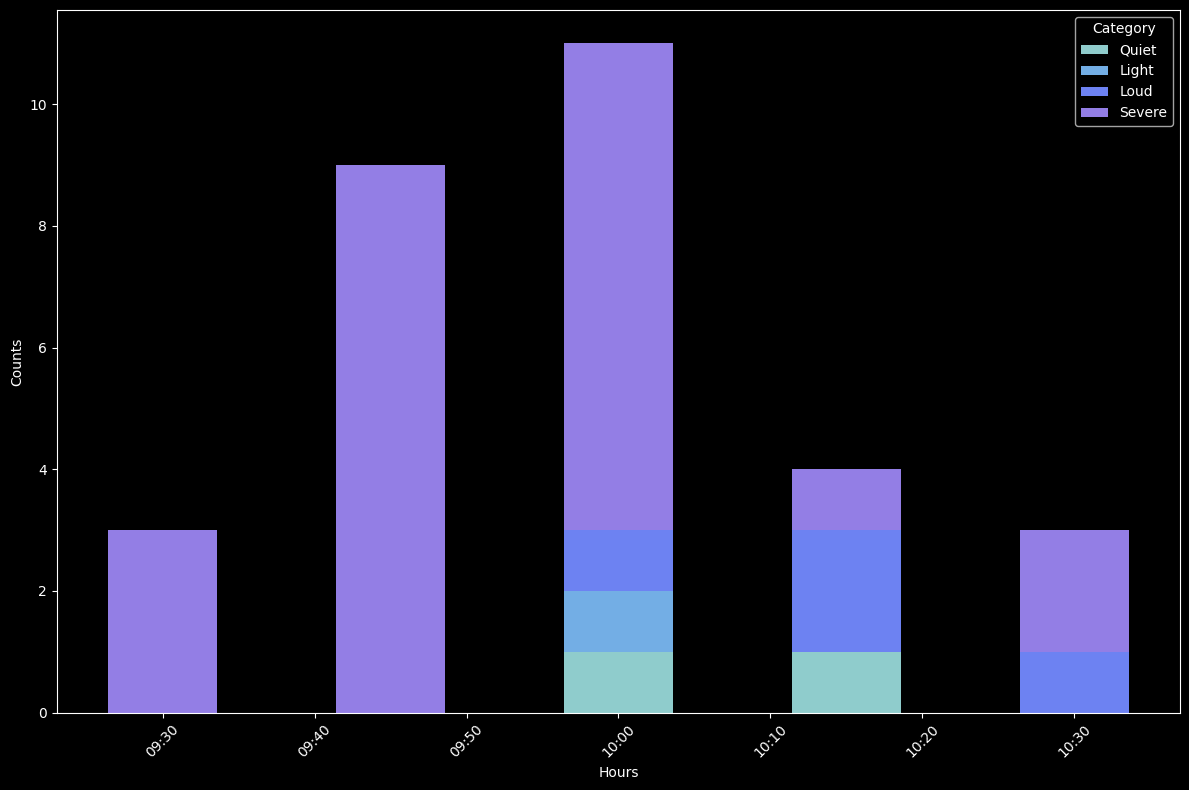

In [24]:
import matplotlib.dates as mdates


plt.style.use('dark_background')
plt.figure(figsize=(12, 8))


colors = {
    "Quiet": "#8fcccc",
    "Light": "#73aee5",
    "Loud": "#6d82f2",
    "Severe": "#937ee5",
}


bottom = None
for category, color in colors.items():
    plt.bar(
        pivot_table.index,
        pivot_table.get(category, 0),
        bottom=bottom,
        color=color,
        label=category,
        width=0.005,
    )
    if bottom is None:
        bottom = pivot_table.get(category, 0)
    else:
        bottom += pivot_table.get(category, 0)



plt.gca().xaxis.set_major_formatter(mdates.DateFormatter("%H:%M"))
plt.xlabel("Hours")
plt.ylabel("Counts")
plt.xticks(rotation=45)
plt.legend(title="Category")


plt.tight_layout()
plt.show()

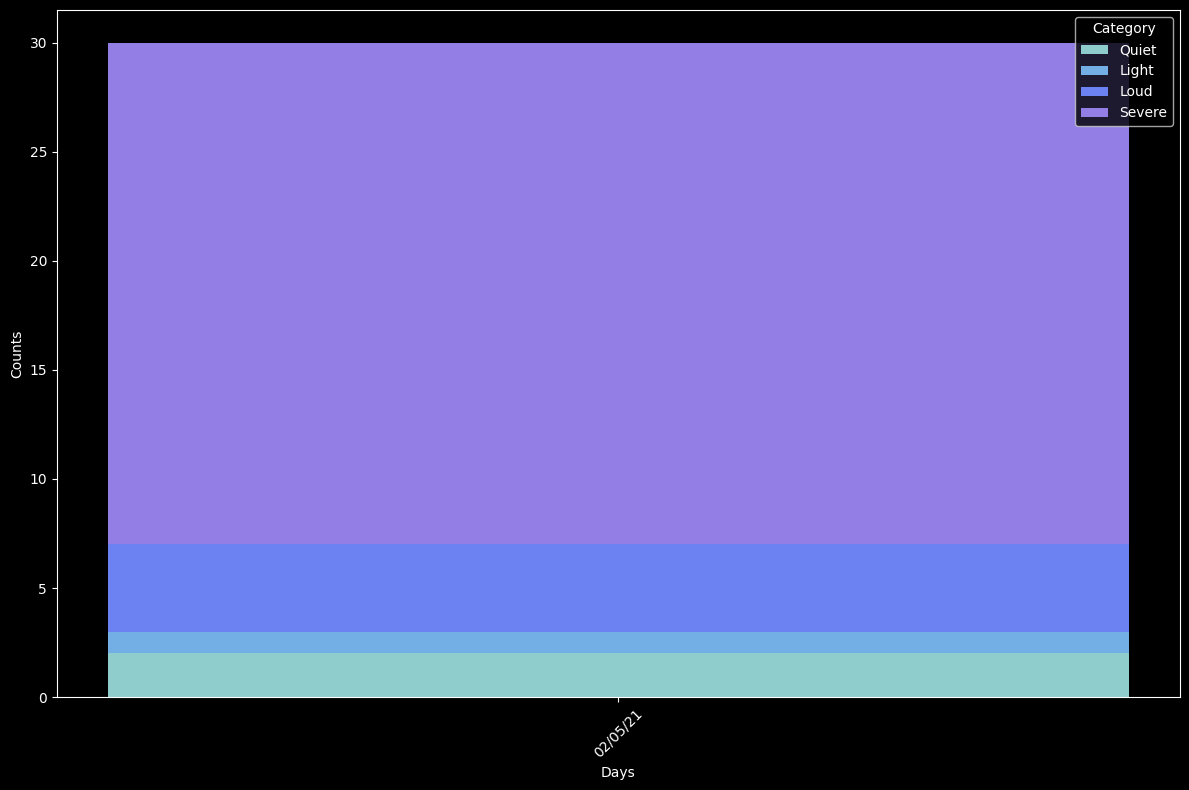

In [25]:
import matplotlib.dates as mdates


plt.style.use('dark_background')
plt.figure(figsize=(12, 8))


colors = {
    "Quiet": "#8fcccc",
    "Light": "#73aee5",
    "Loud": "#6d82f2",
    "Severe": "#937ee5",
}


bottom = None
for category, color in colors.items():
    plt.bar(
        pivot_table_daily.index,
        pivot_table_daily.get(category, 0),
        bottom=bottom,
        color=color,
        label=category,
        width=0.5,
    )
    if bottom is None:
        bottom = pivot_table_daily.get(category, 0)
    else:
        bottom += pivot_table_daily.get(category, 0)


plt.gca().xaxis.set_major_formatter(mdates.DateFormatter("%d/%m/%y"))
plt.xticks(pivot_table_daily.index)

plt.xlabel("Days")
plt.ylabel("Counts")
plt.xticks(rotation=45)
plt.legend(title="Category")


plt.tight_layout()
plt.show()

In [26]:
pivot_table_reset_index = pivot_table.reset_index()


api_json_object = json.loads(df.to_json(orient="records", date_format="iso"))


with open(f"flight-user-{date}.json", "w") as f:
    json.dump(api_json_object, f, indent=4)

f.close()

api_json_object[:5]

[{'event_type': 'snore',
  'version': 1035,
  'snore_count': 3,
  'avg_db': 31.62,
  'max_db': 50.31,
  'start_snore_event_timestamp': '09-41-55.732',
  'max_snore_db': 44.93,
  'avg_snore_db': 44.56,
  'noise_level': 30.96,
  'datetime': '2021-05-02T09:42:03.000',
  'noise_increase_percentage': 43.9276485788,
  'category': 'Severe'},
 {'event_type': 'snore',
  'version': 1035,
  'snore_count': 1,
  'avg_db': 33.92,
  'max_db': 55.34,
  'start_snore_event_timestamp': '09-42-52.855',
  'max_snore_db': 44.41,
  'avg_snore_db': 44.41,
  'noise_level': 33.44,
  'datetime': '2021-05-02T09:43:03.000',
  'noise_increase_percentage': 32.8050239234,
  'category': 'Severe'},
 {'event_type': 'snore',
  'version': 1035,
  'snore_count': 6,
  'avg_db': 34.85,
  'max_db': 52.95,
  'start_snore_event_timestamp': '09-43-11.853',
  'max_snore_db': 48.49,
  'avg_snore_db': 45.25,
  'noise_level': 34.11,
  'datetime': '2021-05-02T09:44:03.000',
  'noise_increase_percentage': 32.6590442685,
  'category': 